# Import, Init

In [826]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, "./classes/")
import cls_nnetwork

# reloading functions without runtime.restart
import importlib
importlib.reload(cls_nnetwork)

<module 'cls_nnetwork' from './classes/cls_nnetwork.py'>

In [827]:
# cut -- train test data with trimmed columns, so that it's more easy to train

nn_manager_cut = cls_nnetwork.NeuralManager(dir_path='../data/csv_to_train/train_test_cut/')

>>> train-test inited:  {'y_test_cut': True, 'X_test_cut': True, 'y_train_cut': True, 'X_train_cut': True}


In [828]:
nn_manager_cut.X_train.shape, nn_manager_cut.X_test.shape

((3182, 12), (795, 12))

In [829]:
nn_manager_cut.X_train[:5]

,Open,High,Low,Vol,AVBLS,NTRAT,TOUTV,TRFEE,BTC_MINED_PDAY,VOL_CHANGE_PDAY,MWNUS_CH_PDAY,NTRAT_CH_PDAY
Date,,,,,,,,,,,,
2019-04-03,4859.3,5278.4,4814.0,13830000.0,1.248330,397961949.0,1.306792e+06,142.102988,425.0,-12780000.0,52351.0,360333.0
2019-04-02,4145.1,4899.6,4143.5,14770000.0,1.215507,397560778.0,3.429199e+06,114.489789,1512.5,-940000.0,61873.0,401171.0
2019-04-01,4102.3,4159.1,4076.8,3220000.0,1.205358,397191600.0,1.744093e+06,61.846737,2162.5,11550000.0,87465.0,369178.0
2019-03-31,4111.8,4121.9,4082.2,2430000.0,1.173566,396808790.0,9.168389e+05,44.614255,1425.0,790000.0,34688.0,382810.0
2019-03-30,4103.7,4138.1,4057.1,2550000.0,1.204920,396430531.0,9.228557e+05,54.673729,2050.0,-120000.0,64109.0,378259.0


## Normalizing

In [830]:
from sklearn.preprocessing import RobustScaler

nn_manager_cut.normalize_X(scaler=RobustScaler)

nn_manager_cut.X_train_normalized[:2]

array([[ 4.52988659e+00,  4.78975360e+00,  4.74139303e+00,
         1.74639067e+02,  1.29200649e+00,  1.87564906e+00,
         1.23854073e-01,  3.30862295e+00, -4.16368286e-01,
        -4.19170152e+02,  2.96856492e+00,  1.36703957e+00],
       [ 3.81150200e+00,  4.42010246e+00,  4.03002493e+00,
         1.86548731e+02,  1.24667529e+00,  1.87347194e+00,
         1.72651774e+00,  2.53817428e+00, -2.38363171e-01,
        -3.08142681e+01,  3.56691540e+00,  1.54784809e+00]])

# Model 

## Splitting data to sequences (Unrolling)

In [831]:
nn_manager_cut.unroll_X_to_sequences(sequence_len=4)

In [832]:
nn_manager_cut.X_test_unrolled[0]

array([[ 3.53689240e+01,  3.51928763e+01,  3.72144714e+01,
         6.43691996e-01,  8.78219500e-01,  3.22867247e+00,
         4.83528350e-01, -2.62732657e-02, -3.42710997e-01,
        -1.29561296e-01,  2.21669940e+00,  6.36455909e-01],
       [ 3.66991727e+01,  3.66113686e+01,  3.65890404e+01,
         7.00706344e-01,  1.06493891e+00,  3.22761248e+00,
        -2.85041974e-01,  1.70764865e-01, -3.42710997e-01,
        -1.29561296e-01,  2.21669940e+00,  6.36455909e-01],
       [ 3.90631428e+01,  3.79461332e+01,  3.74674023e+01,
         1.03303665e+00,  1.34978675e+00,  3.22633882e+00,
        -8.60041445e-02,  5.25127690e-01, -3.41687980e-01,
        -8.42312423e-01,  1.90828686e+00,  8.10769348e-01],
       [ 3.74178590e+01,  3.81480361e+01,  3.90945838e+01,
         7.63548826e-01,  1.35460228e+00,  3.22495080e+00,
         6.05842104e-02,  7.35483801e-01, -3.57033248e-01,
         7.15703157e-01,  3.41691933e+00,  9.04069166e-01]])

In [833]:
# goes up by one sequence -- compare this cell result vs previous
nn_manager_cut.X_test_unrolled[1]

array([[ 3.66991727e+01,  3.66113686e+01,  3.65890404e+01,
         7.00706344e-01,  1.06493891e+00,  3.22761248e+00,
        -2.85041974e-01,  1.70764865e-01, -3.42710997e-01,
        -1.29561296e-01,  2.21669940e+00,  6.36455909e-01],
       [ 3.90631428e+01,  3.79461332e+01,  3.74674023e+01,
         1.03303665e+00,  1.34978675e+00,  3.22633882e+00,
        -8.60041445e-02,  5.25127690e-01, -3.41687980e-01,
        -8.42312423e-01,  1.90828686e+00,  8.10769348e-01],
       [ 3.74178590e+01,  3.81480361e+01,  3.90945838e+01,
         7.63548826e-01,  1.35460228e+00,  3.22495080e+00,
         6.05842104e-02,  7.35483801e-01, -3.57033248e-01,
         7.15703157e-01,  3.41691933e+00,  9.04069166e-01],
       [ 3.65447733e+01,  3.69161259e+01,  3.78081799e+01,
         6.42551709e-01,  1.35107044e+00,  3.22358723e+00,
         7.93558608e-03,  7.70429879e-01, -3.59079284e-01,
         3.31283313e-01,  6.84514963e+00,  8.84127896e-01]])

In [834]:
shape = nn_manager_cut.X_train_unrolled.shape
shape, shape[0]*shape[1]*shape[2]

((3178, 4, 12), 152544)

## Base Model Combining

In [835]:
nn_manager_cut.X_train.shape[1]

12

[n_seq-n_steps in MLM example elaboration](z_MlMastery%20LSTM%20for%20TS%20.ipynb#n_seq-n_steps)<br>
(We can parameterize this and define the number of subsequences as n_seq and the number of time steps per subsequence as n_steps. [[source]](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=We%20can%20parameterize%20this%20and))

In [836]:
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal

n_steps_subseq = 2
n_seq = 2
n_features = nn_manager_cut.X_train.shape[1]
weights_init = GlorotNormal()

conv1D_0 = Conv1D(filters=64, kernel_size=1, activation='relu', padding='causal', kernel_initializer=weights_init)
conv1D_1 = Conv1D(filters=64, kernel_size=1, activation='relu', padding='causal')
# conv1D_2 = Conv1D(filters=64, kernel_size=1, activation='relu', padding='causal')
# conv1D_3 = Conv1D(filters=64, kernel_size=1, activation='relu', padding='causal')

# src: 
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=A%20convolutional%20neural
template = [
    TimeDistributed(conv1D_0, input_shape=(None, n_steps_subseq, n_features)),
    TimeDistributed(conv1D_1),
#     TimeDistributed(conv1D_2),
#     TimeDistributed(conv1D_3),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    LSTM(50, activation='relu'),
    Dense(50),
    Dense(25),
    Dense(1)
]

In [837]:
training_params = dict(optimizer='adam', loss='mae', metrics=['mae'])


nn_manager_cut.model_combine(template=template, compile_dict=training_params)

>>> model compiled
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_219 (TimeDi (None, None, 2, 64)       832       
_________________________________________________________________
time_distributed_220 (TimeDi (None, None, 2, 64)       4160      
_________________________________________________________________
time_distributed_221 (TimeDi (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_222 (TimeDi (None, None, 64)          0         
_________________________________________________________________
lstm_67 (LSTM)               (None, 50)                23000     
_________________________________________________________________
dense_79 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_80 (Dense)             (None

True

## Model Training with Starting architecture

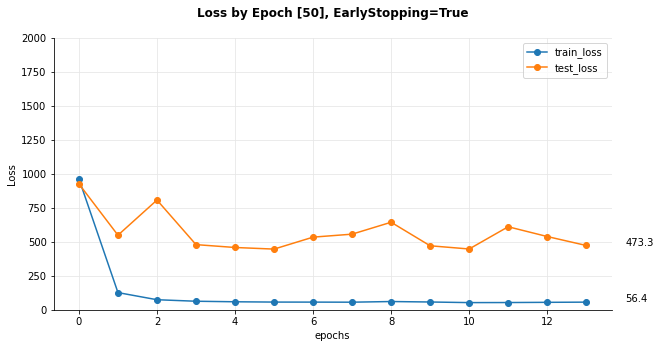

In [838]:
# %%time
nn_manager_cut.model_fit(n_epoch=50, 
                           n_seq=n_seq, 
                           n_steps=n_steps_subseq, 
                           verbose=0, 
                           return_results=True, 
                           print_charts=True,
                           early_stopping=True
                        )
plt.ylim(0,2e3);

We see that after drop of loss in first 10 epochs we receive type of a flatline in test_loss. This is a signal, that  current model is not enough complex for this type of data

In [839]:
# nn_manager_cut.model.predict(nn_manager_cut.X_test_unrolled[1].reshape)

# Model Tunning

## Base Model with changed time frames
one of the possible reasons for the poor loss is that 

# Playground

In [840]:
# sh = nn_manager_cut.X_test_unrolled[1].shape

# X_pred = nn_manager_cut.X_test_unrolled[1].reshape(int(sh[0]/n_steps_subseq), n_steps_subseq, n_features)

